<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1">Data preprocessing</a></span><ul class="toc-item"><li><span><a href="#Data-clearing" data-toc-modified-id="Data-clearing-1.1">Data clearing</a></span></li></ul></li><li><span><a href="#Create-model" data-toc-modified-id="Create-model-2">Create model</a></span></li><li><span><a href="#Draw-picture-of-loss-and-val_loss" data-toc-modified-id="Draw-picture-of-loss-and-val_loss-3">Draw picture of loss and val_loss</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-4">Prediction</a></span></li><li><span><a href="#Submission" data-toc-modified-id="Submission-5">Submission</a></span></li></ul></div>

# Data preprocessing

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import time
import re
from nltk.stem import WordNetLemmatizer # for lemmatizer words
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer # text to word sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords

In [2]:
test = pd.read_csv("Data/testData.tsv", header=0, sep='\t', quoting=3)
train = pd.read_csv("Data/labeledTrainData.tsv",header=0, sep='\t', quoting=3)

In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
test.shape, train.shape

((25000, 2), (25000, 3))

check proportion of positive-negative texts

In [5]:
train[train.sentiment == 1].count() 

id           12500
sentiment    12500
review       12500
dtype: int64

In [6]:
train['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

## Data clearing
   - make lower register of words
   - drop all junk symbols 
   - lemmatize of noun and verb form
   - drop stop_words

In [7]:
stop_words=stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [8]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]' ,'' ,text , re.UNICODE) # drop trash symbols
    text = [lemmatizer.lemmatize(word) for word in text.split(" ")] # split text on words for noun
    text = [lemmatizer.lemmatize(word, "v") for word in text] # for verb
    text = [word for word in text if not word in stop_words] 
    return " ".join(text)

In [9]:
train['Preparing_Reviews'] = train.review.apply(lambda x: clear_text(x))

In [10]:
train.head()

,id,sentiment,review,Preparing_Reviews
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",stuff go moment mj ive start listen music watc...
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war world timothy hines entertain film...
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",film start manager nicholas bell give welcome ...
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",must assume praise film greatest film opera ev...
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious 80 ex...


In [11]:
train['Preparing_Reviews'][0]

'stuff go moment mj ive start listen music watch odd documentary watch wiz watch moonwalker maybe want get certain insight guy think wa really cool eighty maybe make mind whether guilty innocent moonwalker part biography part feature film remember go see cinema wa originally release ha subtle message mjs feel towards press also obvious message drug bad mkaybr br visually impressive course michael jackson unless remotely like mj anyway go hate find bore may call mj egotist consent make movie mj fan would say make fan true really nice himbr br actual feature film bite finally start 20 minute exclude smooth criminal sequence joe pesci convince psychopathic powerful drug lord want mj dead bad beyond mj overhear plan nah joe pescis character rant want people know supply drug etc dunno maybe hate mjs music.<br /><br />lots cool thing like mj turn car robot whole speed demon sequence. also, director must patience saint come film kiddy bad sequence usually director hate work one kid let alone 

In [12]:
print("Max count words:", train['Preparing_Reviews'].apply(lambda x: len(x.split(" "))).max())
print("Min count words:", np.\
      percentile(train['Preparing_Reviews'].apply(lambda x: len(x.split(" "))),95))
print("Mean count words:", train['Preparing_Reviews'].apply(lambda x: len(x.split(" "))).mean())

Max count words: 1483
Min count words: 337.0
Mean count words: 129.61704


  - receive word and them frequencies
  - convert text to sequences numbers

In [13]:
features = 5000
tokenizer = Tokenizer(num_words=features)
tokenizer.fit_on_texts(train['Preparing_Reviews'])
X_train_list = tokenizer.texts_to_sequences(train['Preparing_Reviews'])

In [14]:
maxlen=200
X_train = pad_sequences(X_train_list, maxlen=maxlen)

In [15]:
y_train = np.array(keras.utils.to_categorical(train.sentiment, 2))

In [16]:
y_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [17]:
X_train_fin, X_valid, y_train_fin, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=17)

# Create model

In [18]:
embed_size = 128

model = keras.Sequential()
model.add(Embedding(input_dim=features, output_dim=embed_size, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 200, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 821,122
Trainable params: 821,122
Non-trainable params: 0
_________________________________________________________________


Setting EarlyStopping and parameters of optimizer and reduceLR

In [19]:
es = EarlyStopping(monitor='val_loss',
            mode='min', # training will stop when quantity monitored stopped decreasing
            verbose=1, # for define epoch where training stopped
            patience=7) # Number of epochs with no improvement after which training will be stopped

In [20]:
lr = 0.001
opt = Adam(learning_rate=lr)

In [21]:
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.7, # new_lr = lr * factor
                            patience=7,
                            verbose=1,
                            mode='min',
                            )

In [22]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=opt)

In [23]:
epochs = 10
batch_size = 128

start = time.time()

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_valid, y_valid))

end = time.time()

duration = end - start
print("\n")
print(" The Model took {} seconds {} minutes to train for {} epochs".\
      format(round(duration), round(duration/60), epochs))

Epoch 1/10
196/196 [==============================] - 312s 2s/step - loss: 0.3949 - accuracy: 0.8172 - val_loss: 0.2361 - val_accuracy: 0.9144
Epoch 2/10
196/196 [==============================] - 426s 2s/step - loss: 0.2536 - accuracy: 0.9022 - val_loss: 0.1756 - val_accuracy: 0.9358
Epoch 3/10
196/196 [==============================] - 437s 2s/step - loss: 0.2051 - accuracy: 0.9230 - val_loss: 0.1485 - val_accuracy: 0.9554
Epoch 4/10
196/196 [==============================] - 465s 2s/step - loss: 0.1636 - accuracy: 0.9403 - val_loss: 0.1143 - val_accuracy: 0.9632
Epoch 5/10
196/196 [==============================] - 459s 2s/step - loss: 0.1420 - accuracy: 0.9497 - val_loss: 0.1029 - val_accuracy: 0.9696
Epoch 6/10
196/196 [==============================] - 465s 2s/step - loss: 0.1138 - accuracy: 0.9605 - val_loss: 0.0643 - val_accuracy: 0.9816
Epoch 7/10
196/196 [==============================] - 485s 2s/step - loss: 0.0959 - accuracy: 0.9677 - val_loss: 0.0602 - val_accuracy: 0.9822

# Draw picture of loss and val_loss

loss and val_loss decrease

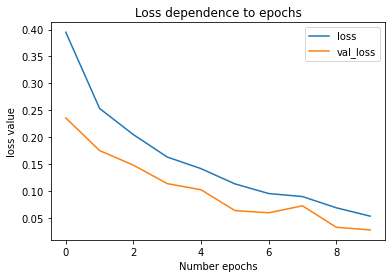

In [28]:
plt.title("Loss dependence to epochs")
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Number epochs')
plt.ylabel('loss value')
plt.legend()
plt.show()

# Prediction

In [29]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [30]:
test.review = test.review.apply(lambda x: clear_text(x))

In [31]:
test.head()

,id,review
0,"""12311_10""",naturally film main theme mortality nostalgia ...
1,"""8348_2""",movie disaster within disaster film full great...
2,"""5828_4""",movie kid saw tonight child love one point kid...
3,"""7186_2""",afraid dark leave impression several different...
4,"""12128_7""",accurate depiction small time mob life film ne...


In [32]:
X_test_list = tokenizer.texts_to_sequences(test['review'])
X_test = pad_sequences(X_test_list, maxlen=maxlen)

In [33]:
prediction = model.predict(X_test)

In [34]:
prediction.shape

(25000, 2)

In [35]:
y_pred = list()
for i in range(prediction.shape[0]):
    y_pred.append(prediction[i].argmax())
y_pred = np.array(y_pred)

In [36]:
y_pred

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [37]:
test['sentiment'] = pd.DataFrame(data=y_pred)

In [38]:
test.head()

,id,review,sentiment
0,"""12311_10""",naturally film main theme mortality nostalgia ...,1
1,"""8348_2""",movie disaster within disaster film full great...,0
2,"""5828_4""",movie kid saw tonight child love one point kid...,1
3,"""7186_2""",afraid dark leave impression several different...,1
4,"""12128_7""",accurate depiction small time mob life film ne...,1


# Submission

In [39]:
submission = test.drop(columns=['review'])

In [40]:
submission.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",1
4,"""12128_7""",1


In [41]:
submission.to_csv('submission.csv', index=False, header=True, quotechar=' ')